# Other preprocessings:

Converts MedicalDecathlonTensors to a version in which:
* We only take from the CT slices the CTs with lungs + just 5% of other stacks
    * First, save the lungs from the Train Split as pngs to analyze where the lungs start

* Apply CLAHE filtering

* Remove the bed on which the patient takes the CT (can apply erode/dilate)

* Segments the lungs using an opensource network with high dice score

# Install

In [1]:
# !pip install -q "monai-weekly[nibabel, skimage, scipy, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil, cucim, openslide, pandas, einops, transformers, mlflow, clearml, matplotlib, tensorboardX, tifffile, imagecodecs, pyyaml, fire, jsonschema, ninja, pynrrd, pydicom, h5py, nni, optuna, onnx, onnxruntime, zarr, lpips, pynvml, huggingface_hub]"

# Import libraries

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

from monai.apps import DecathlonDataset
from monai.data import DataLoader
from monai.transforms import (
    LoadImageD,
    Compose,
    LoadImageD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt
import random

#### Set seeds

In [3]:
import sys
from tqdm import tqdm
import pickle as pkl

In [4]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

## TRAIN

In [5]:
def read_memoized_data(path, split_name):
    crt_path = f'{path}/{split_name}'
    
    no_patients = len(os.listdir(f'{crt_path}/images'))
    
    patients = []

    for patient_id in range(no_patients):
        img = torch.load(f'{crt_path}/images/patient_{patient_id}.pt')
        label = torch.load(f'{crt_path}/labels/patient_{patient_id}.pt')
        patients.append({"image": img.squeeze(0), "label": label.squeeze(0)})
    
    return patients

    

In [6]:
train_images_path = './plots/TRAIN'

In [7]:
memoized_path = f'/raid/CataChiru/MedicalDecathlonTensors/'


train_dataset = read_memoized_data(memoized_path, 'training')
train_length = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False) #, num_workers = 1)

In [8]:
if not os.path.exists(train_images_path):
     os.mkdir(train_images_path)

if not os.path.exists(f'{train_images_path}/patient0'):
    for i in range(train_length):
        os.mkdir(f'{train_images_path}/patient{i}')

# for patient_id in tqdm(range(train_length)):
#     img = train_dataset[patient_id]['image']

#     for stack in range(img.shape[-1]):
#         print(f'Current stack {stack} / {img.shape[-1]}')
#         plt.imshow(img[..., stack].squeeze(0), cmap = 'gray')
#         plt.gca().invert_yaxis()
#         plt.gca().set_axis_off()

#         plt.savefig(f'{train_images_path}/patient{patient_id}/slice{stack}.png')
#         plt.close()


# patient = 0
# print(f'Epoch {patient}/{len(train_dataset)}')

# for stack in range(img.shape[-1]):
#     print(f'Current stack {stack} / {img.shape[-1]}')
#     plt.imshow(img[..., stack].squeeze(0), cmap = 'gray')
#     plt.show()    


In [9]:
# Memoize stacks in between we find the lungs
# Based on the radiologist, some CTs start from kidney area up to the cervical backbone
patient_useful_slices = {
    0 : {'start': 60, 'stop': 557},
    1 : {'start': 20 , 'stop': 243},
    2 : {'start': 0, 'stop': 213},
    3 : {'start': 48, 'stop': 437},
    4 : {'start': 52, 'stop': 258},
    5 : {'start': 59, 'stop': 244},
    6 : {'start': 9, 'stop': 122},
    7 : {'start': 44, 'stop': 260},
    8 : {'start': 3, 'stop': 237},
    9 : {'start': 330 , 'stop': 623},
    10 : {'start': 56, 'stop': 280},
    11 : {'start': 26, 'stop': 292},
    12 : {'start': 0, 'stop': 108},
    13 : {'start': 10, 'stop': 227},
    14 : {'start': 25, 'stop': 231},
    15 : {'start': 35, 'stop': 280},
    16 : {'start': 37, 'stop': 262},
    17 : {'start': 29, 'stop': 266},
    18 : {'start': 48, 'stop': 261},
    19 : {'start': 65, 'stop': 275},
    20 : {'start': 145, 'stop': 520},
    21 : {'start': 0, 'stop': 397},
    22 : {'start': 9, 'stop': 225},
    23 : {'start': 6, 'stop': 227},
    24 : {'start': 15, 'stop': 239},
    25 : {'start': 40, 'stop': 149},
    26 : {'start': 30, 'stop': 231},
    27 : {'start': 49, 'stop': 295},
    28 : {'start': 33, 'stop': 217},
    29 : {'start': 50, 'stop': 311},
    30 : {'start': 0, 'stop': 213},
    31 : {'start': 22, 'stop': 248},
    32 : {'start': 88, 'stop': 493},
    33 : {'start': 116, 'stop': 439},
    34 : {'start': 40, 'stop': 300},
    35 : {'start': 0, 'stop': 227},
    36 : {'start': 0, 'stop': 198},
    37 : {'start': 0, 'stop': 120},
    38 : {'start': 0, 'stop': 203},
    39 : {'start': 44, 'stop': 228},
    40 : {'start': 0, 'stop': 229},
    41 : {'start': 35, 'stop': 250},
    42 : {'start': 48, 'stop': 243},
    43 : {'start': 5, 'stop': 230},
    44 : {'start': 88, 'stop': 314},
    45 : {'start': 7, 'stop': 220},
    46 : {'start': 11, 'stop': 232},
    47 : {'start': 21, 'stop': 229},
    48 : {'start': 4, 'stop': 255},
    49 : {'start': 2, 'stop': 122},
    50 : {'start': 14, 'stop': 119}
}

# Further used in convert_dataset.ipynb to save the useful slices

In [10]:
import cv2

In [82]:
# Based on the bounding box obtained from MSD_EDA.ipynb from the training set (92, 424, 119, 371)
# We heuristcallly select the bounding box for the lungs, in order to crop the images, to remove the bed and other noise sources
bbox_2d = (60, 450, 119, 425)

h_min, h_max, w_min, w_max = bbox_2d

In [99]:
images_I_went_through_when_determining_bbox = [('Patient', 'slice'), (0, 0), (1, 23), (3,71), (14, 25), (50, 50)]

torch.Size([512, 512, 589])


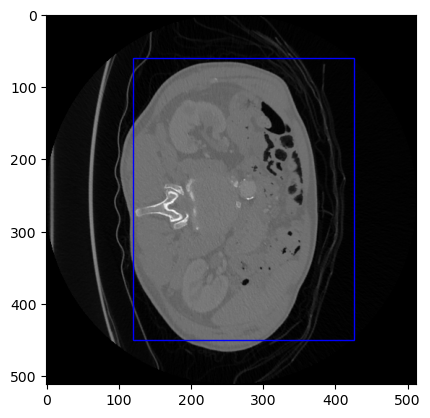

torch.Size([512, 512, 267])


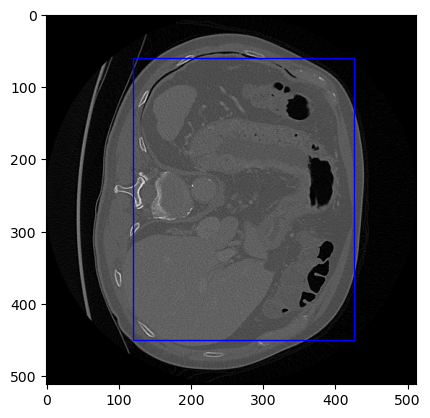

torch.Size([512, 512, 450])


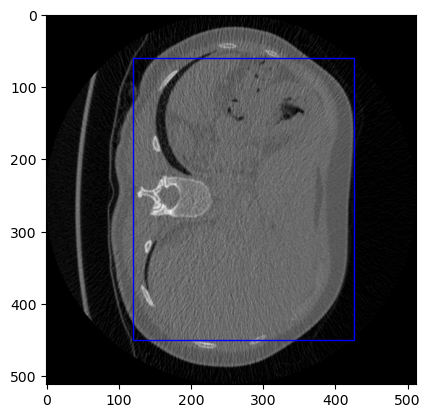

torch.Size([512, 512, 249])


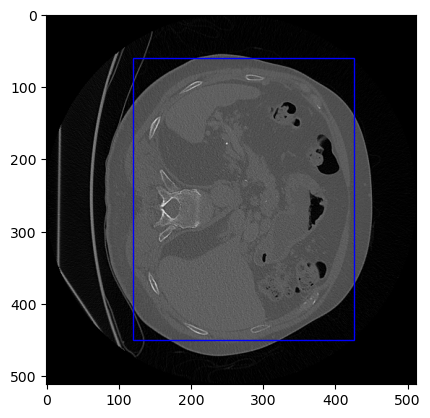

torch.Size([512, 512, 125])


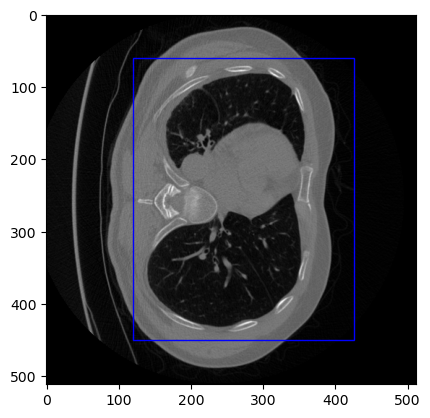

In [100]:
for idx in range(1, len(images_I_went_through_when_determining_bbox)):
    patient_id, slice_id = images_I_went_through_when_determining_bbox[idx]
    train_slice = train_dataset[patient_id]['image']
    print(train_slice.shape)
    plt.imshow(train_slice[..., slice_id], cmap = 'gray')
    # Add the rectangle
    plt.gca().add_patch(plt.Rectangle((w_min, h_min), w_max - w_min, h_max - h_min, fill=False, edgecolor='blue', lw=1))
    plt.show()

In [12]:
np.max(train_slice[..., 0]), np.min(train_slice[..., 0])

(1405.0, -1024.0)

In [13]:
clahe = cv2.createCLAHE(clipLimit = 4.0)
final_img = clahe.apply(train_slice[..., 0].astype(np.uint8))

In [14]:
np.max(final_img), np.min(final_img)

(255, 0)

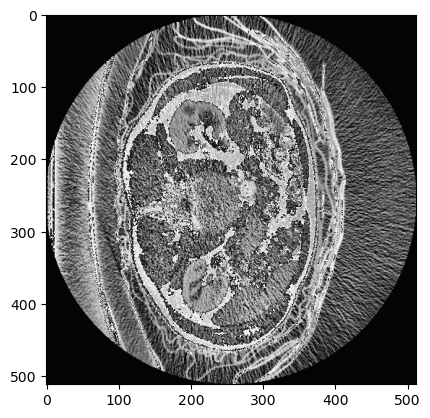

In [15]:
plt.imshow(final_img, cmap = 'gray')
plt.show()

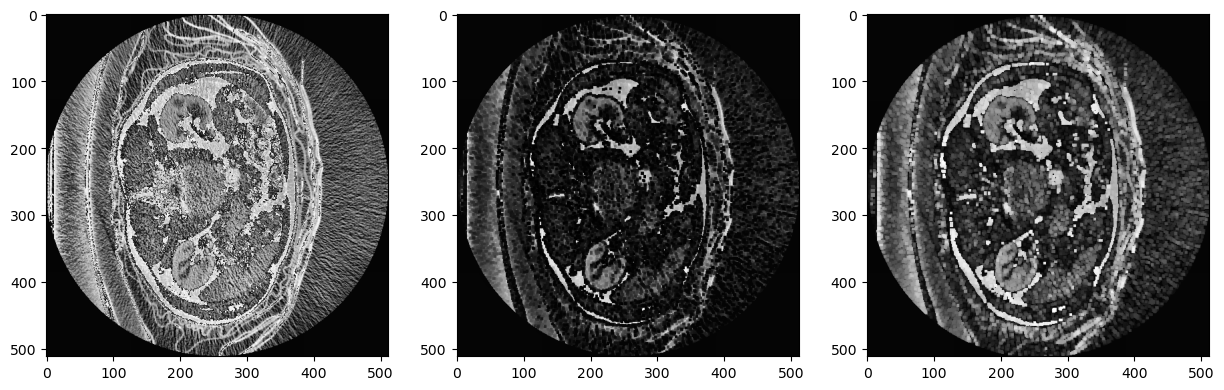

In [16]:
# Errode, dilate image

no_iters = 3
kernel = np.ones((2, 2), np.uint8)
eroded = cv2.erode(final_img, kernel, iterations = no_iters)
dilated = cv2.dilate(eroded, kernel, iterations = no_iters)


fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(final_img, cmap = 'gray')
axes[1].imshow(eroded, cmap = 'gray')
axes[2].imshow(dilated, cmap = 'gray')
plt.show()

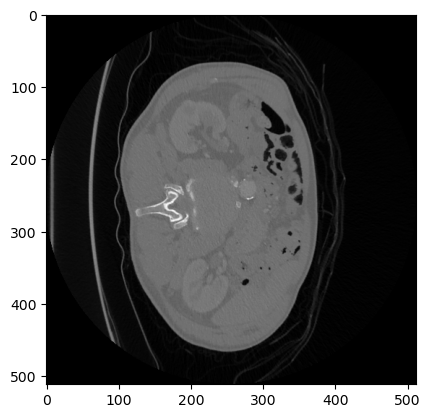

In [17]:
final_img2 = (train_slice[..., 0] - np.min(train_slice[..., 0])) / ((np.max(train_slice[..., 0]) - np.min(train_slice[..., 0])))

plt.imshow(final_img2, cmap = 'gray')
plt.show()

In [18]:
np.max(final_img2), np.min(final_img2)

(1.0, 0.0)

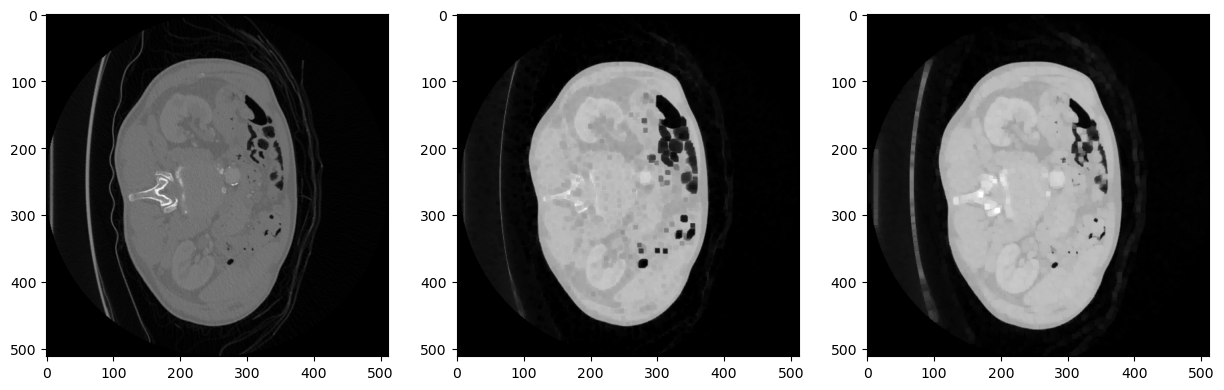

In [19]:
# Errode, dilate image

no_iters2 = 5
kernel2 = np.ones((2, 2), np.uint8)
eroded2 = cv2.erode(final_img2.numpy(), kernel2, iterations = no_iters2)
dilated2 = cv2.dilate(eroded2, kernel2, iterations = no_iters2)


fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(final_img2, cmap = 'gray')
axes[1].imshow(eroded2, cmap = 'gray')
axes[2].imshow(dilated2, cmap = 'gray')
plt.show()

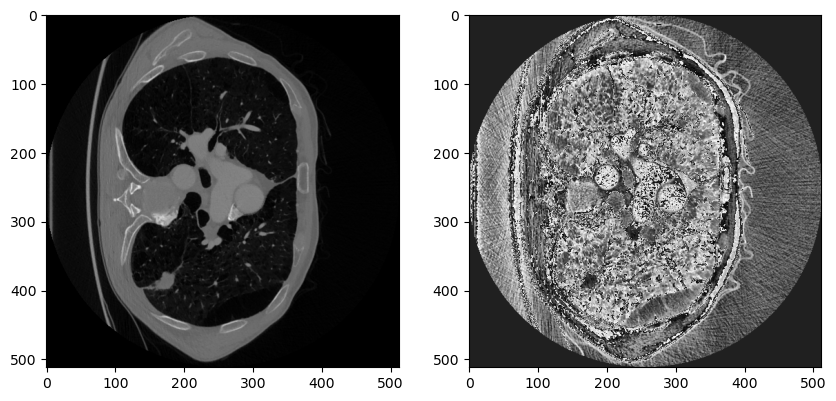

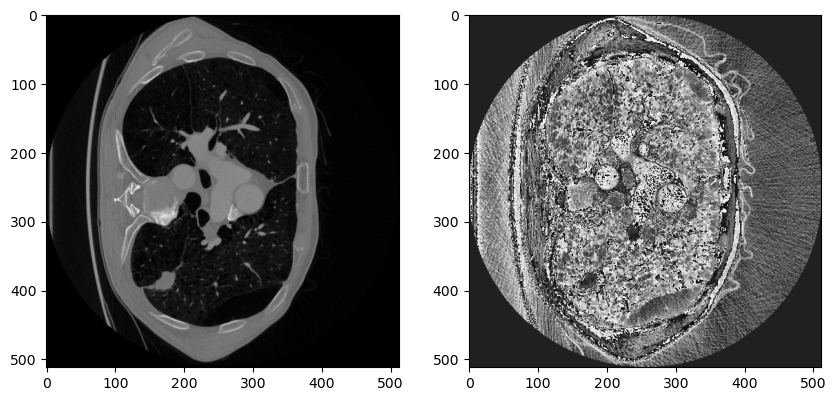

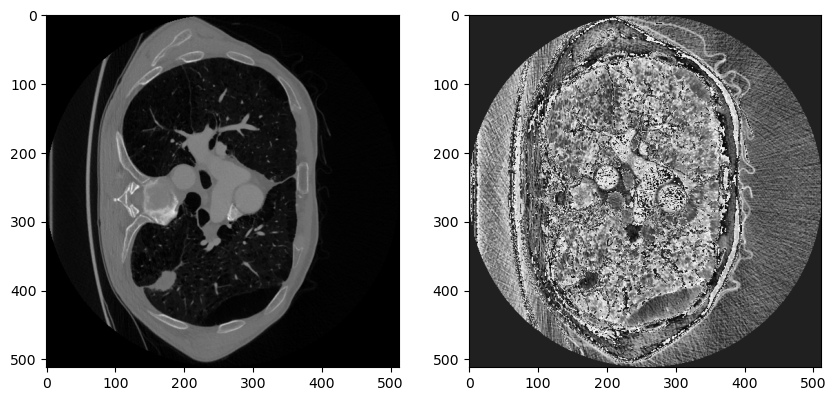

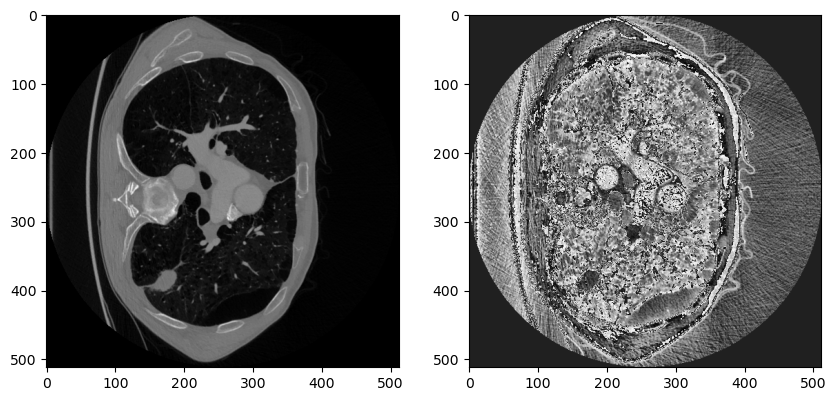

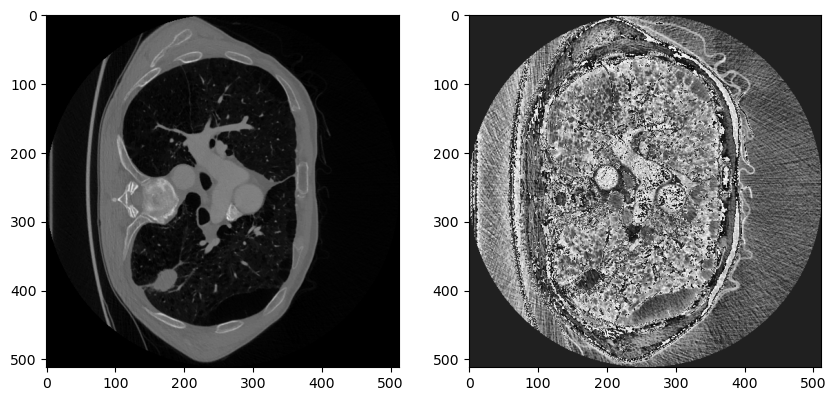

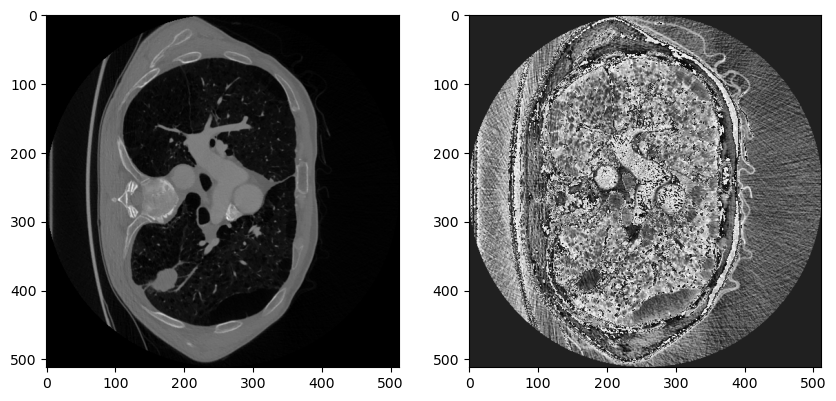

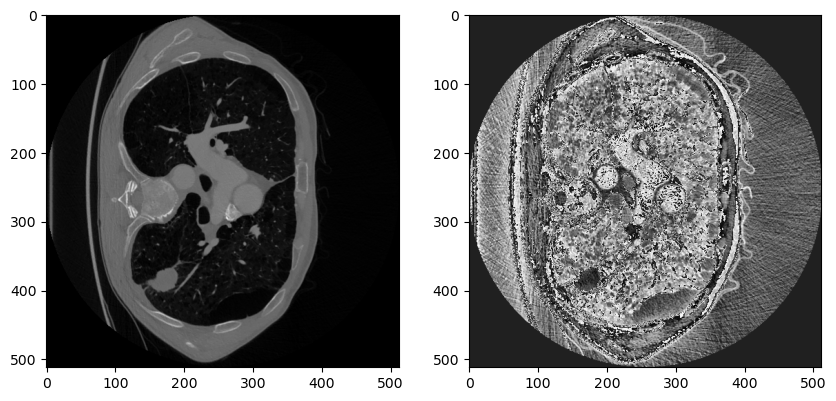

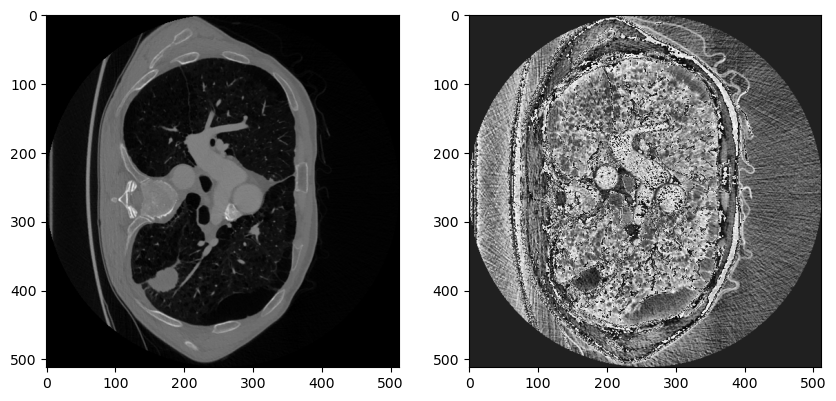

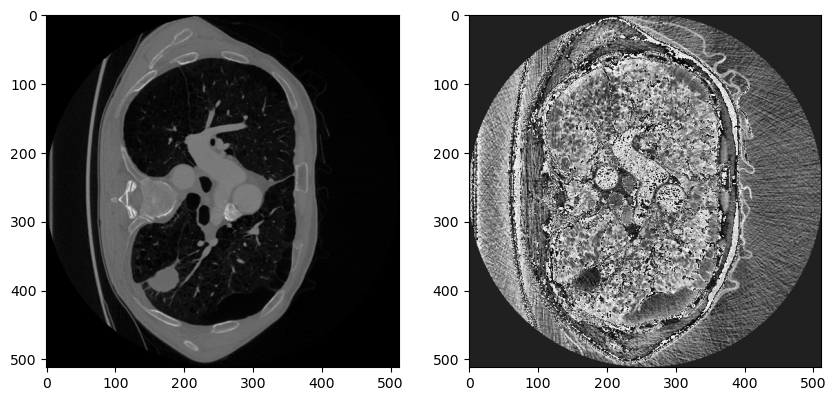

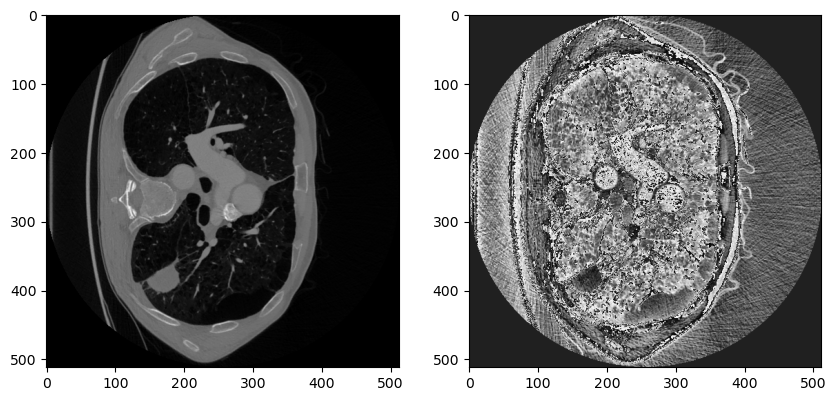

In [20]:

for i in range(340, 350):
    clahe = cv2.createCLAHE(clipLimit=2)
    final_img = clahe.apply(train_slice[..., i].numpy().astype(np.uint8)) + 30

    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    axes[0].imshow(train_slice[..., i].squeeze(0), cmap = 'gray')
    axes[1].imshow(final_img, cmap = 'gray')
    plt.show()

In [21]:
# !pip install object_detector

In [22]:
from object_detector import ObjectDetector

In [44]:
obj = ObjectDetector(weights='yolov5s', classes='lung')

SystemExit: Trained model not found

In [39]:
net(train_slice.unsqueeze(0).unsqueeze(0).float())

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 512, 512, 589]

In [ ]:
clahe = cv2.createCLAHE(clipLimit=5)
final_img = clahe.apply(a.numpy().astype(np.uint8))

error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:804: error: (-215:Assertion failed) m.dims <= 2 in function 'Mat'
